In [1]:
%matplotlib inline

import pandas as pd
import stumpy
import numpy as np
import numpy.testing as npt
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import urllib
import ssl
import io
import os
import time
import zipfile
from scipy.io import loadmat
from tqdm import trange, tqdm
from collections import OrderedDict

Naive transcription of table 2 in paper.

In [2]:
def ostinato(tss, m):
    bsf_rad, ts_ind, ss_ind = np.inf, 0, 0
    k = len(tss)
    for j in trange(k, desc='time series'):
        if j < (k - 1):
            h = j + 1
        else:
            h = 0
        
        mp = stumpy.stump(tss[j], m, tss[h], ignore_trivial=False)
        si = np.argsort(mp[:, 0])
        for q in si:
            rad = mp[q, 0]
            if rad >= bsf_rad:
                break
            for i in range(k):
                if ~np.isin(i, [j, h]):
                    rad = np.max((
                            rad, 
                            np.min(stumpy.core.mass_absolute(tss[j][q:q+m], tss[i]))
                                ))
                    if rad >= bsf_rad:
                        break
            if rad < bsf_rad:
                bsf_rad, ts_ind, ss_ind = rad, j, q
    
    return bsf_rad, ts_ind, ss_ind

In [3]:
def dataset_mt_dna():
    context = ssl.SSLContext()  # Ignore SSL certificate verification for simplicity
    T_url = 'https://sites.google.com/site/consensusmotifs/dna.zip?attredirects=0&d=1'
    T_raw_bytes = urllib.request.urlopen(T_url, context=context).read()
    T_data = io.BytesIO(T_raw_bytes)
    T_zipfile = zipfile.ZipFile(T_data)
    animals = ['python', 'hippo', 'red_flying_fox', 'alpaca']
    dna = []
    for a in animals:
        with T_zipfile.open(f'dna/data/{a}.mat') as f:
            dna.append((a, loadmat(f)['ts'].flatten().astype(float)))
    return OrderedDict(dna)

data = dataset_mt_dna()
colors = {'python': 'tab:blue', 'hippo': 'tab:green', 'red_flying_fox': 'tab:purple', 'alpaca': 'tab:red'}

Clustering obtained from using majority of mtDNA sequences. The paper says that they truncated to 16000 data points but to reproduce the sequences in Fig. 9 left they need to be truncated to 15000.

To reproduce the clustering the standardised euclidean distance has to be used.

Text(0, 0.5, 'standardised euclidean distance')

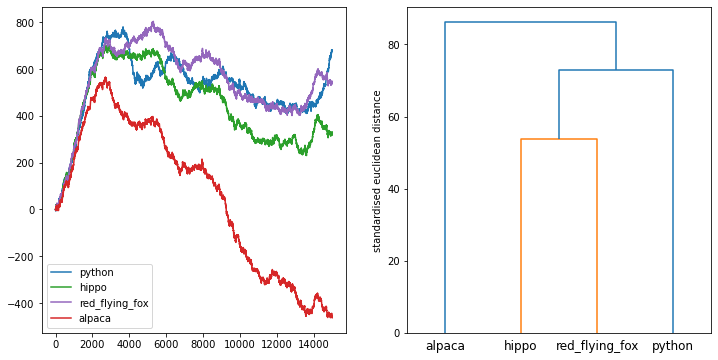

In [4]:
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.special import comb
from itertools import combinations

fig, ax = plt.subplots(ncols=2, figsize=(12,6))

# sequences in Fig 9 left
truncate = 15000
for k, v in data.items():
    ax[0].plot(v[:truncate], label=k, color=colors[k])
ax[0].legend()

# clustering in Fig 9 left
truncate = 16000
dp = np.zeros(int(comb(4, 2)))
for i, a_c in enumerate(combinations(data.keys(), 2)):
    dp[i] = stumpy.core.mass(data[a_c[0]][:truncate], data[a_c[1]][:truncate])
Z = linkage(dp, optimal_ordering=True)
dendrogram(Z, labels=[k for k in data.keys()], ax=ax[1])
ax[1].set_ylabel('standardised euclidean distance')

In [5]:
m = 1000
rad, ts_ind, ss_ind = ostinato([v for v in data.values()], m)
print(f'Best radius {rad} found in time series {ts_ind} at index {ss_ind}')

time series: 100%|██████████| 4/4 [25:07<00:00, 376.89s/it]

Best radius 389.56642565806413 found in time series 2 at index 46


Get the consensus motifs and perform clustering on them.

{'icoord': [[25.0, 25.0, 35.0, 35.0],
  [15.0, 15.0, 30.0, 30.0],
  [5.0, 5.0, 22.5, 22.5]],
 'dcoord': [[0.0, 2.0073187443276947, 2.0073187443276947, 0.0],
  [0.0, 3.788856527663464, 3.788856527663464, 2.0073187443276947],
  [0.0, 4.0141646771949935, 4.0141646771949935, 3.788856527663464]],
 'ivl': ['python', 'red_flying_fox', 'hippo', 'alpaca'],
 'leaves': [0, 2, 1, 3],
 'color_list': ['C1', 'C0', 'C0']}

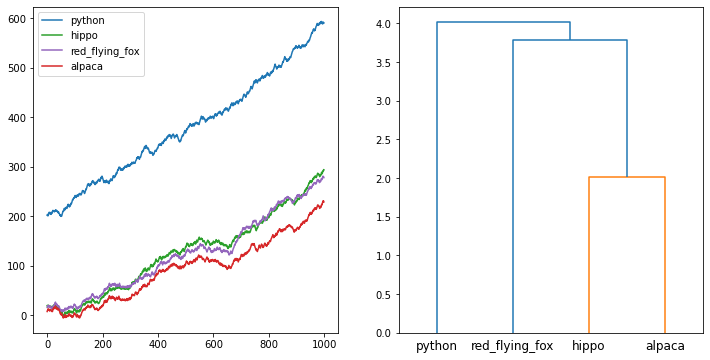

In [6]:
consensus_motifs = OrderedDict()
best_motif = list(data.items())[ts_ind][1][ss_ind:ss_ind+m]
for i, (k, v) in enumerate(data.items()):
    if i == ts_ind:
        consensus_motifs[k] = best_motif
    else:
        ind = np.argmin(stumpy.core.mass(best_motif, v))
        consensus_motifs[k] = v[ind:ind+m]

        
fig, ax = plt.subplots(ncols=2, figsize=(12, 6))
# plot the consensus motifs
for animal, motif in consensus_motifs.items():
    ax[0].plot(motif, label=animal, color=colors[animal])
ax[0].legend()
# cluster consensus motifs
dp = np.zeros(int(comb(4, 2)))
for i, motif in enumerate(combinations(list(consensus_motifs.values()), 2)):
    dp[i] = stumpy.core.mass(motif[0], motif[1])
Z = linkage(dp, optimal_ordering=True)
dendrogram(Z, labels=[k for k in consensus_motifs.keys()])

In [7]:
# Load electrical demand sample dataset. Segment data into roughly 44 hour time series.
def dataset_electrical_demand():
    context = ssl.SSLContext()  # Ignore SSL certificate verification for simplicity
    T_url = 'https://sites.google.com/site/consensusmotifs/ElectricalDemand.zip?attredirects=0&d=1'
    T_raw_bytes = urllib.request.urlopen(T_url, context=context).read()
    T_data = io.BytesIO(T_raw_bytes)
    T_zipfile = zipfile.ZipFile(T_data)
    with T_zipfile.open('ElectricalDemand/ElectricalDemandSample_Data.mat') as f:
        T_mat = loadmat(f)
    data = T_mat['house1'].flatten()
    return data[19999:159999].reshape((7, -1)).astype(float)